# Importando pacotes

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns; sns.set(style="whitegrid")
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime
import html5lib
import requests

from statsmodels.tsa.stattools import adfuller, coint as adf,coint
from sklearn.linear_model import LinearRegression
from nsepy import get_history
from datetime import date
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from yahoofinancials import YahooFinancials
from IPython.display import clear_output
from pandas_datareader import data as pdr
from bs4 import BeautifulSoup
from bateleur.bateleur import *

C:\Users\henrique.trevisan\Anaconda3\lib\site-packages\bateleur\bateleur.py 

"Quer café?" 
	 Matheus Vizzotto


# Funções Importantes

In [2]:
# MQO para encontrar o coeficiente de cointegração e criando a serie do spread
def OLS(data_ticker1, data_ticker2):
    spread = sm.OLS(data_ticker1,data_ticker2)
    spread = spread.fit()
    return data_ticker1 + (data_ticker2 * -spread.params[0]), spread.params[0]


# ADF test
def ADF(spread):
    return ts.adfuller(spread) # H0: Raiz unitária.


# Encontra o coeficiente de cointegração e realiza o ADF test
def ADF_test(data_ticker1, data_ticker2):
    ols = OLS(data_ticker1, data_ticker2)
    spread = ols[0]
    gamma = ols[1]
    return ADF(spread),gamma


# Encontra os pares cointegrados
def find_cointegrated_pairs_mod(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    gammas_matrix= np.ones((n, n))
    keys = data.keys()
    for i in range(n):
        for j in range(i+1, n):
            S1 = keys[i]
            S2 = keys[j]
            result = ADF_test(data[S1], data[S2])
            gammas_matrix[i, j] =result[1] # gamma
            pvalue = result[0][1] # pvalue
            pvalue_matrix[i, j] = pvalue
    return pvalue_matrix, gammas_matrix


# Ordenando os melhores pares
def top_coint_pairs(data,pvalue_matrix,gamma, alpha, n): 
#alpha = nivel de significancia para o teste ADF
#n = top n ativos com o menor pvalue    
    
    pvalues_f = pvalues[np.where(pvalues < alpha)] # pvalores menores que alpha
    stock_a = data.columns[list(np.where(pvalues < alpha))[0]] # relacionando o pvalor com a ação A
    stock_b = data.columns[list(np.where(pvalues < alpha))[1]] # relacionando o pvalor com a ação B
    gammas_f = gammas[np.where(pvalues < alpha)] # relacionando o pvalor com o gamma
    N = len(list(np.where(pvalues < alpha)[0])) # quantidade de pares cointegrados

    d = []
    for i in range(N):
      d.append(
            {
                'Stock A': stock_a[i],
                'Stock B': stock_b[i],
                'P-Values': pvalues_f[i],
                'Gamma': gammas_f[i]
            }
        )

    return pd.DataFrame(d).sort_values(by="P-Values").iloc[:n,]


# Calcula os retornos da carteira e armazenando em um data frame
def calculate_profit(spread, threshold, par1, par2, resumo):
    
    log_ret = spread.diff() # log return eh o incremento
    dias = spread.index
    z_score = (spread-spread.mean())/spread.std()
    portfolio_return = []
    pos = 0 # 0: sem posição aberta
            # 1: Comprei o meu portfolio h = (1,-gamma)
            # -1: Vendi o meu portfolio h = -(1,-gamma)

    dias_abertura = []
    dias_fechamento = []

    count = 0
    dia_abertura = 0
    dia_fechamento = 0

    for i in range(1,len(z_score)):
                        
        if (z_score[i] > threshold) and (pos == 0):
            pos = -1

            count += 1
            dia_abertura = dias[i]
            retornos_op = []


        elif (z_score[i] < -threshold)  and (pos == 0):
            pos = 1            

            count += 1
            dia_abertura = dias[i]
            retornos_op = []

        else:

          if (pos == 1) and (z_score[i] < -0.75):
            portfolio_return.append(log_ret[i]*pos)
            retornos_op.append(log_ret[i]*pos)


          elif (pos == 1) and (z_score[i] >= -0.75):
            portfolio_return.append(log_ret[i]*pos)
            pos = 0

            dia_fechamento = dias[i]
            delta_dias = dia_fechamento - dia_abertura
            retornos_op.append(log_ret[i]*pos)
            retorno_op = pd.Series(retornos_op).sum()
            
            resumo.append([count, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2])

            
          elif (pos == -1) and (z_score[i] > 0.75):
            portfolio_return.append(log_ret[i]*pos)
            retornos_op.append(log_ret[i]*pos)


          elif (pos == -1) and (z_score[i] <= 0.75):
            portfolio_return.append(log_ret[i]*pos)
            pos = 0

            dia_fechamento = dias[i]
            delta_dias = dia_fechamento - dia_abertura
            retornos_op.append(log_ret[i]*pos)
            retorno_op = pd.Series(retornos_op).sum()

            resumo.append([count, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2])

          else: 
            if pos != 0:
              dia_fechamento = dias[i]
              delta_dias = dia_fechamento - dia_abertura
              retornos_op.append(log_ret[i]*pos)
              retorno_op = pd.Series(retornos_op).sum()

              resumo.append([count, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2])
            
            
            pos = 0

    total_ret = pd.Series(portfolio_return).sum()

    return total_ret, resumo


# Calcula o expoente de hurst
def get_hurst_exponent(time_series):
    
    # Definindo o intervalo de taus
    max_tau = round(len(time_series)/4)
    taus = range(2, max_tau)

    # Calculando a variável k
    k = [np.std(np.subtract(time_series[tau:], time_series[:-tau])) for tau in taus]
    
    'To calculate the Hurst exponent, we first calculate the standard deviation of the differences between a series and its lagged version, for a range of possible lags.'

    # Calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(taus), np.log(k), 1)
    
    'We then estimate the Hurst exponent as the slope of the log-log plot of the number of lags versus the mentioned standard deviations.'

    return reg[0]

# Pegando Dados

In [3]:
tickers = ['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'AIG',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ANET',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'CHRW',
 'CDNS',
 'CZR',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CERN',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'CEG',
 'COO',
 'CPRT',
 'GLW',
 'CTVA',
 'COST',
 'CTRA',
 'CCI',
 'CSX',
 'CMI',
 'CVS',
 'DHI',
 'DHR',
 'DRI',
 'DVA',
 'DE',
 'DAL',
 'XRAY',
 'DVN',
 'DXCM',
 'FANG',
 'DLR',
 'DFS',
 'DISCA',
 'DISCK',
 'DISH',
 'DIS',
 'DG',
 'DLTR',
 'D',
 'DPZ',
 'DOV',
 'DOW',
 'DTE',
 'DUK',
 'DRE',
 'DD',
 'DXC',
 'EMN',
 'ETN',
 'EBAY',
 'ECL',
 'EIX',
 'EW',
 'EA',
 'EMR',
 'ENPH',
 'ETR',
 'EOG',
 'EPAM',
 'EFX',
 'EQIX',
 'EQR',
 'ESS',
 'EL',
 'ETSY',
 'RE',
 'EVRG',
 'ES',
 'EXC',
 'EXPE',
 'EXPD',
 'EXR',
 'XOM',
 'FFIV',
 'FDS',
 'FAST',
 'FRT',
 'FDX',
 'FITB',
 'FRC',
 'FE',
 'FIS',
 'FISV',
 'FLT',
 'FMC',
 'F',
 'FTNT',
 'FTV',
 'FBHS',
 'FOXA',
 'FOX',
 'BEN',
 'FCX',
 'AJG',
 'GRMN',
 'IT',
 'GE',
 'GNRC',
 'GD',
 'GIS',
 'GPC',
 'GILD',
 'GL',
 'GPN',
 'GM',
 'GS',
 'GWW',
 'HAL',
 'HIG',
 'HAS',
 'HCA',
 'PEAK',
 'HSIC',
 'HSY',
 'HES',
 'HPE',
 'HLT',
 'HOLX',
 'HD',
 'HON',
 'HRL',
 'HST',
 'HWM',
 'HPQ',
 'HUM',
 'HII',
 'HBAN',
 'IEX',
 'IDXX',
 'ITW',
 'ILMN',
 'INCY',
 'IR',
 'INTC',
 'ICE',
 'IBM',
 'IP',
 'IPG',
 'IFF',
 'INTU',
 'ISRG',
 'IVZ',
 'IPGP',
 'IQV',
 'IRM',
 'JBHT',
 'JKHY',
 'J',
 'JNJ',
 'JCI',
 'JPM',
 'JNPR',
 'K',
 'KEY',
 'KEYS',
 'KMB',
 'KIM',
 'KMI',
 'KLAC',
 'KHC',
 'KR',
 'LHX',
 'LH',
 'LRCX',
 'LW',
 'LVS',
 'LDOS',
 'LEN',
 'LLY',
 'LNC',
 'LIN',
 'LYV',
 'LKQ',
 'LMT',
 'L',
 'LOW',
 'LUMN',
 'LYB',
 'MTB',
 'MRO',
 'MPC',
 'MKTX',
 'MAR',
 'MMC',
 'MLM',
 'MAS',
 'MA',
 'MTCH',
 'MKC',
 'MCD',
 'MCK',
 'MDT',
 'MRK',
 'FB',
 'MET',
 'MTD',
 'MGM',
 'MCHP',
 'MU',
 'MSFT',
 'MAA',
 'MRNA',
 'MHK',
 'MOH',
 'TAP',
 'MDLZ',
 'MPWR',
 'MNST',
 'MCO',
 'MS',
 'MOS',
 'MSI',
 'MSCI',
 'NDAQ',
 'NTAP',
 'NFLX',
 'NWL',
 'NEM',
 'NWSA',
 'NWS',
 'NEE',
 'NLSN',
 'NKE',
 'NI',
 'NDSN',
 'NSC',
 'NTRS',
 'NOC',
 'NLOK',
 'NCLH',
 'NRG',
 'NUE',
 'NVDA',
 'NVR',
 'NXPI',
 'ORLY',
 'OXY',
 'ODFL',
 'OMC',
 'OKE',
 'ORCL',
 'OGN',
 'OTIS',
 'PCAR',
 'PKG',
 'PARA',
 'PH',
 'PAYX',
 'PAYC',
 'PYPL',
 'PENN',
 'PNR',
 'PBCT',
 'PEP',
 'PKI',
 'PFE',
 'PM',
 'PSX',
 'PNW',
 'PXD',
 'PNC',
 'POOL',
 'PPG',
 'PPL',
 'PFG',
 'PG',
 'PGR',
 'PLD',
 'PRU',
 'PEG',
 'PTC',
 'PSA',
 'PHM',
 'PVH',
 'QRVO',
 'PWR',
 'QCOM',
 'DGX',
 'RL',
 'RJF',
 'RTX',
 'O',
 'REG',
 'REGN',
 'RF',
 'RSG',
 'RMD',
 'RHI',
 'ROK',
 'ROL',
 'ROP',
 'ROST',
 'RCL',
 'SPGI',
 'CRM',
 'SBAC',
 'SLB',
 'STX',
 'SEE',
 'SRE',
 'NOW',
 'SHW',
 'SBNY',
 'SPG',
 'SWKS',
 'SJM',
 'SNA',
 'SEDG',
 'SO',
 'LUV',
 'SWK',
 'SBUX',
 'STT',
 'STE',
 'SYK',
 'SIVB',
 'SYF',
 'SNPS',
 'SYY',
 'TMUS',
 'TROW',
 'TTWO',
 'TPR',
 'TGT',
 'TEL',
 'TDY',
 'TFX',
 'TER',
 'TSLA',
 'TXN',
 'TXT',
 'TMO',
 'TJX',
 'TSCO',
 'TT',
 'TDG',
 'TRV',
 'TRMB',
 'TFC',
 'TWTR',
 'TYL',
 'TSN',
 'USB',
 'UDR',
 'ULTA',
 'UAA',
 'UA',
 'UNP',
 'UAL',
 'UNH',
 'UPS',
 'URI',
 'UHS',
 'VLO',
 'VTR',
 'VRSN',
 'VRSK',
 'VZ',
 'VRTX',
 'VFC',
 'VTRS',
 'V',
 'VNO',
 'VMC',
 'WAB',
 'WMT',
 'WBA',
 'WM',
 'WAT',
 'WEC',
 'WFC',
 'WELL',
 'WST',
 'WDC',
 'WRK',
 'WY',
 'WHR',
 'WMB',
 'WTW',
 'WYNN',
 'XEL',
 'XYL']

In [4]:
# Dados para calcular os pares cointegrados
start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2022, 1, 1)

data = pdr.get_data_yahoo(tickers, start, end)['Adj Close']
data = np.log(data)
data_ = data.dropna(subset = [data.index[1]], axis = 1).iloc[1:].dropna()

# Dados para calcular o Índice de Sharpe
stock_data = yf.download("^GSPC", start="1990-01-01", end="2022-04-30")
prices = stock_data["Adj Close"]
returns = prices.pct_change()

[*********************100%***********************]  500 of 500 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 694234800, endDate = 1641006000
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [112]:
# Dados para calcular o retorno do índice
index = yf.download("^GSPC", start="1991-12-31", end="2022-01-01")
prices_index = index["Adj Close"]
returns_index = prices_index.pct_change()

[*********************100%***********************]  1 of 1 completed


# Histórico do S&P 500

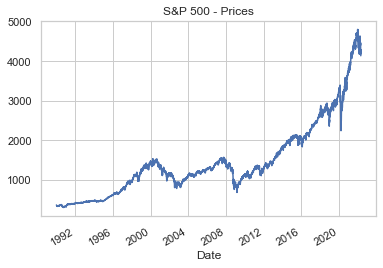

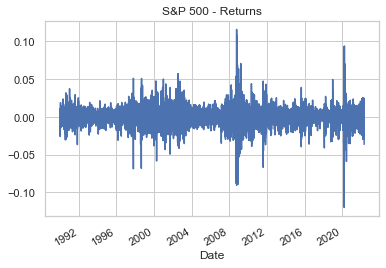

In [5]:
# Comportamento dos preços e dos retornos
plot1 = plt.figure(1)
prices.plot(title="S&P 500 - Prices")

plot2 = plt.figure(2)
returns.plot(title="S&P 500 - Returns")

plt.show()

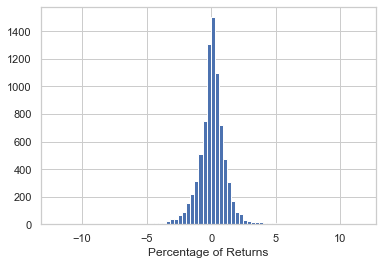

In [6]:
# Histograma dos retornos
returns_percent = returns * 100
returns_percent.dropna(inplace=True)

plt.hist(returns_percent, bins=75)
plt.xlabel("Percentage of Returns")
plt.show()

In [7]:
# Calculando o Índice Sharpe do S&P500 para períodos móveis de 252 dias
db_sharpe = returns

annual_returns = []
annual_risks = []
dts = []

for row in range(252, len(db_sharpe)):
    
    dts.append(list(db_sharpe.index)[row])

    ts = db_sharpe[row-252:row]

    daily_return = np.mean(ts)
    annual_return = ((1 + daily_return) ** 252) - 1
    
    daily_risk = np.std(ts)
    annual_risk = daily_risk * np.sqrt(252)

    annual_returns.append(annual_return)
    annual_risks.append(annual_risk)

df_sharpe = pd.DataFrame(annual_returns)
df_sharpe.columns = ['Annual Returns']
df_sharpe["Annual Risks"] = annual_risks
df_sharpe["Sharpe"] = df_sharpe["Annual Returns"] / df_sharpe["Annual Risks"]
df_sharpe["Date"] = dts
df_sharpe
# df_sharpe.to_excel(r'C:\Users\henrique.trevisan\OneDrive - Bateleur\Área de Trabalho\Documentos\UFRGS\sp500.xlsx', index = True)

,Annual Returns,Annual Risks,Sharpe,Date
0,-0.074832,0.158709,-0.471504,1990-12-31
1,-0.070313,0.158469,-0.443700,1991-01-02
2,-0.078489,0.158841,-0.494135,1991-01-03
3,-0.083356,0.159205,-0.523579,1991-01-04
4,-0.076981,0.158945,-0.484320,1991-01-07
...,...,...,...,...
7889,0.034109,0.153923,0.221595,2022-04-25
7890,0.038165,0.154014,0.247802,2022-04-26
7891,0.009572,0.156582,0.061128,2022-04-27
7892,0.012548,0.156593,0.080129,2022-04-28


[*********************100%***********************]  1 of 1 completed


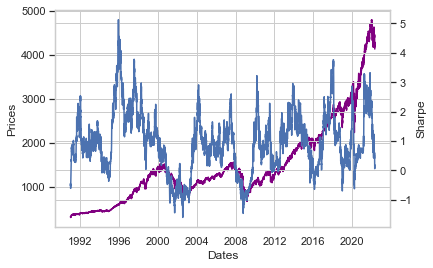

In [10]:
# Pega uma base auxiliar para ter o mesmo período para o gráfico
stock_data_ = yf.download("^GSPC", start="1990-12-31", end="2022-04-30")
prices_ = stock_data_["Adj Close"]

fig,ax1 = plt.subplots()

ax1.set_xlabel('Dates')
ax1.set_ylabel('Prices')

ax1.plot(df_sharpe["Date"], stock_data_["Adj Close"], color = "purple")

ax2 = ax1.twinx()
ax2.set_ylabel('Sharpe')

ax2.plot(df_sharpe["Date"], df_sharpe["Sharpe"])

plt.show()

<AxesSubplot:xlabel='Date'>

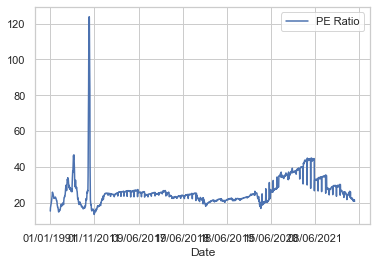

In [11]:
# Pegando os dados do PE Ratio do S&P500
pe_ratio = pd.read_csv(r'C:\Users\henrique.trevisan\OneDrive - Bateleur\Área de Trabalho\Documentos\UFRGS\2021.02\Tópicos em Finanças\Trabalho\05_colados_como_valores\S&P500_PE.csv', sep = ';')
pe_ratio = pe_ratio.set_index("Date")
pe_ratio['PE Ratio'] = pe_ratio['PE Ratio'].astype(float)
pe_ratio.plot()

# Calculando o Expoente de Hurst

#### Vamos primeiramente fazer alguns testes para a fórmula:

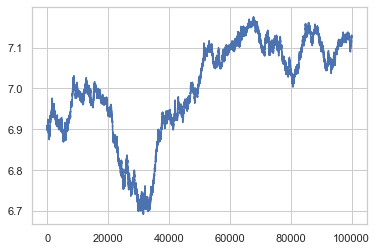

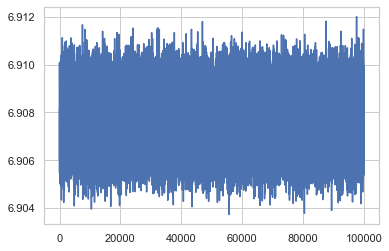

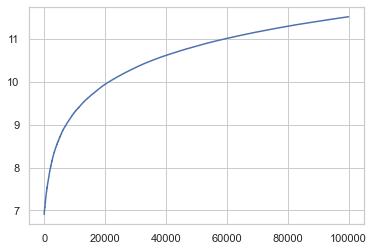

In [12]:
# Criando uma Gometric Brownian Motion (H = 0.5)
gbm = log(cumsum(randn(100000))+1000)
plt.plot(gbm)
plt.show()

# Criando uma Mean-Reverting Series (H < 0,5)
mr = log(randn(100000)+1000)
plt.plot(mr)
plt.show()

# Criando uma Trending Series (H > 0,5)
tr = log(cumsum(randn(100000)+1)+1000)
plt.plot(tr)
plt.show()

In [13]:
#Calculando o Expoente de Hurst para cada uma delas
print("Hurst(GBM):   %s" % get_hurst_exponent(gbm))
print("Hurst(MR):    %s" % get_hurst_exponent(mr))
print("Hurst(TR):    %s" % get_hurst_exponent(tr))

Hurst(GBM):   0.555023596263446
Hurst(MR):    -0.0003155508159552771
Hurst(TR):    0.6525815062353482


#### Agora que vimos que a fórmula está funcionando, vamos aplicá-la aos Índices Sharpe e PE Ratio:

In [15]:
hrst_sharpe = np.array(df_sharpe["Sharpe"])
hrst_pe = np.array(pe_ratio['PE Ratio'])

print("Hurst(Sharpe):   %s" % get_hurst_exponent(hrst_sharpe))
print("Hurst(PE Ratio):    %s" % get_hurst_exponent(hrst_pe))

Hurst(Sharpe):   0.18021120755054817
Hurst(PE Ratio):    0.0629530916148477


#### Como o Expoente de Hurst é menor que 0,5 nos dois casos, podemos concluir que existe uma tendência das séries regredirem para a média histórica.

Vamos olhar agora o comportamento do Expoente de Hurst ao longo do tempo nas duas séries

<AxesSubplot:xlabel='Dates'>

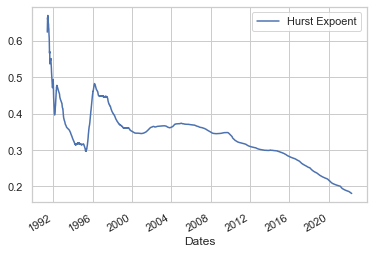

In [18]:
# Testando a sensibilidade do Hurst para todo o período do Índice Sharpe, com um mínimo de 100 observações.

db_original_sharpe = df_sharpe.set_index("Date")
db_calculo_sharpe = hrst_sharpe

hursts = []
dates = []

# Determine the series sizes to be tested
for row in range(100, len(db_calculo_sharpe)):

    ts = db_calculo_sharpe[:row]

    hurst_exp = get_hurst_exponent(ts)
    
    hursts.append(hurst_exp)
    
    dates.append(list(db_original_sharpe.index)[row])
    
df_hurst_sharpe = pd.DataFrame(np.array(np.array(np.array(hursts).tolist()).flatten()).tolist())
df_hurst_sharpe.columns = ['Hurst Expoent']
df_hurst_sharpe['Dates'] = dates
df_hurst_sharpe = df_hurst_sharpe.set_index("Dates")
df_hurst_sharpe.plot()

<AxesSubplot:xlabel='Dates'>

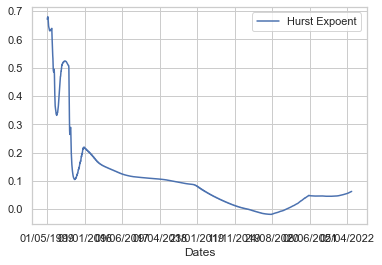

In [19]:
# Testando a sensibilidade do Hurst para todo o período do PE Ratio, com um mínimo de 100 observações.

db_original_pe = pe_ratio
db_calculo_pe = hrst_pe
hursts_pe = []
dates_pe = []

# Determine the series sizes to be tested
for row in range(100, len(db_calculo_pe)):

    ts = db_calculo_pe[:row]

    hurst_exp = get_hurst_exponent(ts)
    
    hursts_pe.append(hurst_exp)
    
    dates_pe.append(list(db_original_pe.index)[row])
    
df_hurst_pe = pd.DataFrame(np.array(np.array(np.array(hursts_pe).tolist()).flatten()).tolist())
df_hurst_pe.columns = ['Hurst Expoent']
df_hurst_pe['Dates'] = dates_pe
df_hurst_pe = df_hurst_pe.set_index("Dates")
df_hurst_pe.plot()

# Calculando os Pesos da Carteira

Vamos mudar um pouco de ambiente, pois os cálculos foram feitos no Excel. Simulamos 3 carteiras: AS-IS, Sharpe e PE Ratio. A primeira consiste em uma alocação 50/50 em todos os períodos, enquanto as outras duas são baseadas nos sinais dos respectivos índices.

** Obs.: Os pesos são rebalanceados mensalmente com base no índice do último dia útil do mês anterior.

In [107]:
pesos_asis = pd.read_csv(r'C:\Users\henrique.trevisan\OneDrive - Bateleur\Área de Trabalho\Documentos\UFRGS\2021.02\Tópicos em Finanças\Trabalho\05_colados_como_valores\weights_ASIS.csv', sep = ';')
pesos_asis = pesos_asis.set_index("Date")
pesos_asis

,Index,Pairs Trading
Date,,
1992-01-02,50%,50%
1992-01-03,50%,50%
1992-01-06,50%,50%
1992-01-07,50%,50%
1992-01-08,50%,50%
...,...,...
2021-12-27,50%,50%
2021-12-28,50%,50%
2021-12-29,50%,50%


In [108]:
pesos_sharpe = pd.read_csv(r'C:\Users\henrique.trevisan\OneDrive - Bateleur\Área de Trabalho\Documentos\UFRGS\2021.02\Tópicos em Finanças\Trabalho\05_colados_como_valores\weights_SHARPE.csv', sep = ';')
pesos_sharpe = pesos_sharpe.set_index("Date")
pesos_sharpe

,Index,Pairs Trading
Date,,
1992-01-02,0%,100%
1992-01-03,0%,100%
1992-01-06,0%,100%
1992-01-07,0%,100%
1992-01-08,0%,100%
...,...,...
2021-12-27,0%,100%
2021-12-28,0%,100%
2021-12-29,0%,100%


In [109]:
pesos_pe = pd.read_csv(r'C:\Users\henrique.trevisan\OneDrive - Bateleur\Área de Trabalho\Documentos\UFRGS\2021.02\Tópicos em Finanças\Trabalho\05_colados_como_valores\weights_PE.csv', sep = ';')
pesos_pe = pesos_pe.set_index("Date")
pesos_pe

,Index,Pairs Trading
Date,,
1992-01-02,50%,50%
1992-01-03,50%,50%
1992-01-06,50%,50%
1992-01-07,50%,50%
1992-01-08,50%,50%
...,...,...
2021-12-27,0%,100%
2021-12-28,0%,100%
2021-12-29,0%,100%


# Calculando os Retornos do Index e Pairs Trading 

### Retornos do Index

In [118]:
returns_index = pd.DataFrame(returns_index)
returns_index.columns = ["Index"]
returns_index

,Index
Date,
1992-01-02,0.000408
1992-01-03,0.004985
1992-01-06,-0.003291
1992-01-07,-0.001340
1992-01-08,0.001677
...,...
2021-12-27,0.013839
2021-12-28,-0.001010
2021-12-29,0.001402


### Retornos do Pairs Trading


Primeiro, vamos encontrar os pares cointegrados e enviar um resumo de todas as operações para o Excel, com dados como: par envolvido, data de abertura, data de fechamento, número da operação e retorno total.

In [ ]:
results = []
resumos = []
alpha = 0.05
n = 5
threshold = 1.5

for j in range(0, int((end-start).days/365)*2-1):

  pvalues, gammas = find_cointegrated_pairs_mod(data_.iloc[126*j:(252+126*j),]) # 1 ano de formação e 6 meses de teste
    
  try:
    coint_pairs_df = top_coint_pairs(data_, pvalues, gammas, alpha, n)

  except:
    continue
  
  for i in range(0,coint_pairs_df.shape[0]):

      S1_name = coint_pairs_df.iloc[i, 0]
      S2_name = coint_pairs_df.iloc[i, 1]
      gamma_1_2 = coint_pairs_df.iloc[i, 3]

      S1 = data_[S1_name].iloc[(252+126*j):(252+126*(j+1))] # periodo de teste
      S2 = data_[S2_name].iloc[(252+126*j):(252+126*(j+1))] # periodo de teste

      # Spread
      spread = S1 - gamma_1_2*S2

      # Pegando o resultado da estratégia
      ret, resumos = calculate_profit(spread, threshold, S1_name, S2_name, resumos)
    

cols = ['Operação', 'Abertura', 'Fechamento', 'Dias', 'Retorno total', 'Ticker 1', 'Ticker 2']
df = pd.DataFrame(resumos, columns = cols)
df['Dias'] = df['Dias'].dt.days
df['Index'] = df['Ticker 1'].astype(str) + '-' + df['Ticker 2'].astype(str) + '-' + df['Operação'].astype(str)
df['Retorno total - exp'] = np.exp(df['Retorno total'])
export(df, name = 'Pairs trading')

Após o tratamento da base resumo em Excel, conseguimos extrair o retorno diário da carteira.

In [129]:
returns_pairs_trading = pd.read_csv(r'C:\Users\henrique.trevisan\OneDrive - Bateleur\Área de Trabalho\Documentos\UFRGS\2021.02\Tópicos em Finanças\Trabalho\05_colados_como_valores\pairs_trading.csv', sep = ';')
returns_pairs_trading = returns_pairs_trading.set_index("Date")
returns_pairs_trading

,Pairs Trading
Date,
1992-01-02,0.000179
1992-01-03,0.000158
1992-01-06,0.000157
1992-01-07,0.000143
1992-01-08,0.000187
...,...
2021-12-27,0.000003
2021-12-28,0.000003
2021-12-29,0.000003


# Calculando os Retornos das Carteiras

Faremos isso no Excel!